In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import itertools
warnings.filterwarnings("ignore")
%matplotlib inline
from tensorflow import keras
import scipy.stats as stats
from feature_engine.outlier_removers import Winsorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
import tensorflow as tfs
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report,roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

In [2]:
df = pd.read_csv("insurance_claims.csv")

In [3]:
df.head()

,months_as_customer,age,policy_number,policy_bind_date,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,...,witnesses,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,fraud_reported
0,328,48,521585,17-10-2014,OH,250/500,1000,1406.91,0,466132,...,2,YES,71610,6510,13020,52080,Saab,92x,2004,Y
1,228,42,342868,27-06-2006,IN,250/500,2000,1197.22,5000000,468176,...,0,?,5070,780,780,3510,Mercedes,E400,2007,Y
2,134,29,687698,06-09-2000,OH,100/300,2000,1413.14,5000000,430632,...,3,NO,34650,7700,3850,23100,Dodge,RAM,2007,N
3,256,41,227811,25-05-1990,IL,250/500,2000,1415.74,6000000,608117,...,2,NO,63400,6340,6340,50720,Chevrolet,Tahoe,2014,Y
4,228,44,367455,06-06-2014,IL,500/1000,1000,1583.91,6000000,610706,...,1,NO,6500,1300,650,4550,Accura,RSX,2009,N


In [4]:
df.shape

(1000, 39)

In [5]:
df.isnull().sum().sum()

0

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 39 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   months_as_customer           1000 non-null   int64  
 1   age                          1000 non-null   int64  
 2   policy_number                1000 non-null   int64  
 3   policy_bind_date             1000 non-null   object 
 4   policy_state                 1000 non-null   object 
 5   policy_csl                   1000 non-null   object 
 6   policy_deductable            1000 non-null   int64  
 7   policy_annual_premium        1000 non-null   float64
 8   umbrella_limit               1000 non-null   int64  
 9   insured_zip                  1000 non-null   int64  
 10  insured_sex                  1000 non-null   object 
 11  insured_education_level      1000 non-null   object 
 12  insured_occupation           1000 non-null   object 
 13  insured_hobbies    

In [7]:
df.authorities_contacted.unique()


array(['Police', 'None', 'Fire', 'Other', 'Ambulance'], dtype=object)

In [8]:
df.collision_type.value_counts()

Rear Collision     292
Side Collision     276
Front Collision    254
?                  178
Name: collision_type, dtype: int64

In [9]:
df["collision_type"] = np.where(df["collision_type"] == "?","missing",df["collision_type"])

In [10]:
df.property_damage.value_counts()

?      360
NO     338
YES    302
Name: property_damage, dtype: int64

In [11]:
df["property_damage"] = np.where(df["property_damage"] == "?","missing",df["property_damage"])

In [12]:
df.police_report_available.value_counts()

NO     343
?      343
YES    314
Name: police_report_available, dtype: int64

In [13]:
df["police_report_available"] = np.where(df["police_report_available"] == "?","missing",df["police_report_available"])

In [14]:
df["policy_bind_date"] = pd.to_datetime(df["policy_bind_date"])
df["incident_date"] = pd.to_datetime(df["incident_date"])

In [15]:
df["date_diff"] = (df["incident_date"]-df["policy_bind_date"]).dt.days

In [16]:
df["make_model"] = df["auto_make"] + "_" + df["auto_model"]

In [17]:
df.drop(["policy_number","insured_zip","incident_location","policy_bind_date","incident_date","auto_make","auto_model"],
        axis = 1,inplace = True)

In [18]:
df.shape

(1000, 34)

In [19]:
df.head()

,months_as_customer,age,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_sex,insured_education_level,insured_occupation,...,witnesses,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_year,fraud_reported,date_diff,make_model
0,328,48,OH,250/500,1000,1406.91,0,MALE,MD,craft-repair,...,2,YES,71610,6510,13020,52080,2004,Y,100,Saab_92x
1,228,42,IN,250/500,2000,1197.22,5000000,MALE,MD,machine-op-inspct,...,0,missing,5070,780,780,3510,2007,Y,3130,Mercedes_E400
2,134,29,OH,100/300,2000,1413.14,5000000,FEMALE,PhD,sales,...,3,NO,34650,7700,3850,23100,2007,N,5371,Dodge_RAM
3,256,41,IL,250/500,2000,1415.74,6000000,FEMALE,PhD,armed-forces,...,2,NO,63400,6340,6340,50720,2014,Y,9260,Chevrolet_Tahoe
4,228,44,IL,500/1000,1000,1583.91,6000000,MALE,Associate,sales,...,1,NO,6500,1300,650,4550,2009,N,256,Accura_RSX


Text(0, 0.5, 'count')

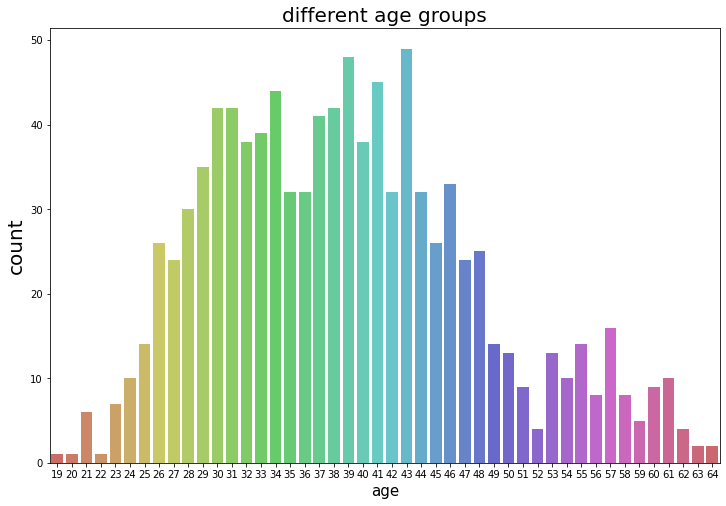

In [20]:
plt.figure(figsize = (12,8))
g = sns.countplot(x="age",data=df,palette='hls')
g.set_title("different age groups", fontsize=20)
g.set_xlabel("age", fontsize=15)
g.set_ylabel("count", fontsize=20)

<AxesSubplot:xlabel='fraud_reported', ylabel='count'>

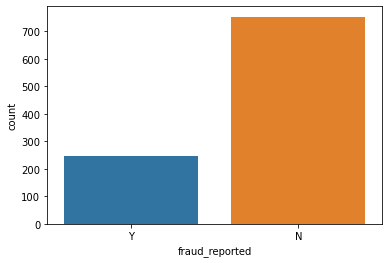

In [21]:
sns.countplot(df.fraud_reported)

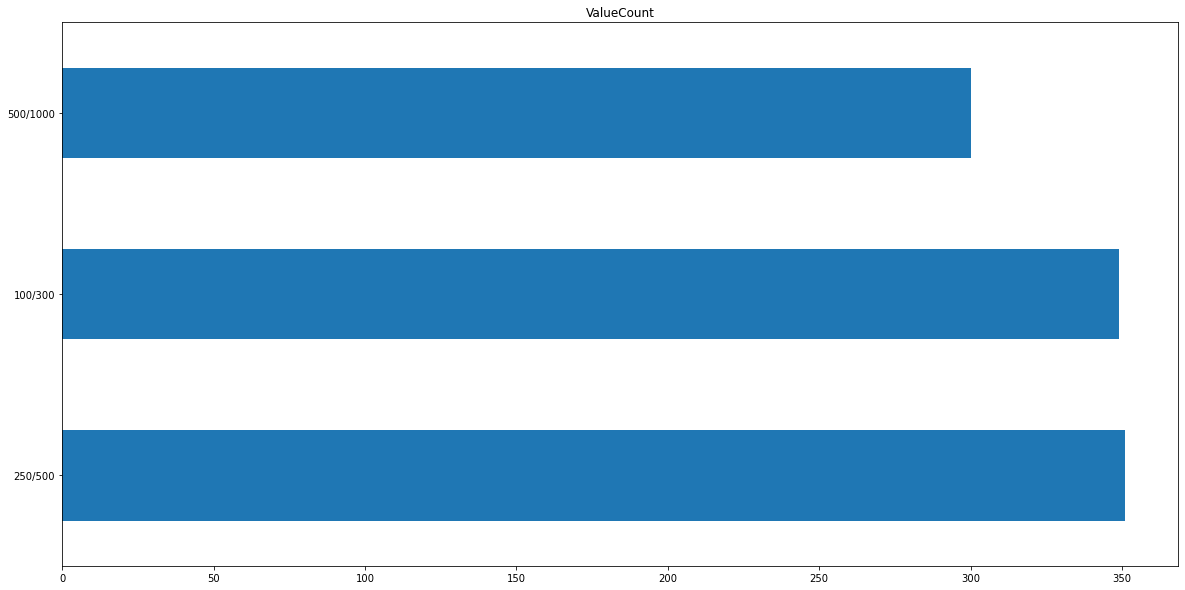

In [22]:
df["policy_csl"].value_counts().plot(kind='barh', figsize=(20,10), title="ValueCount");

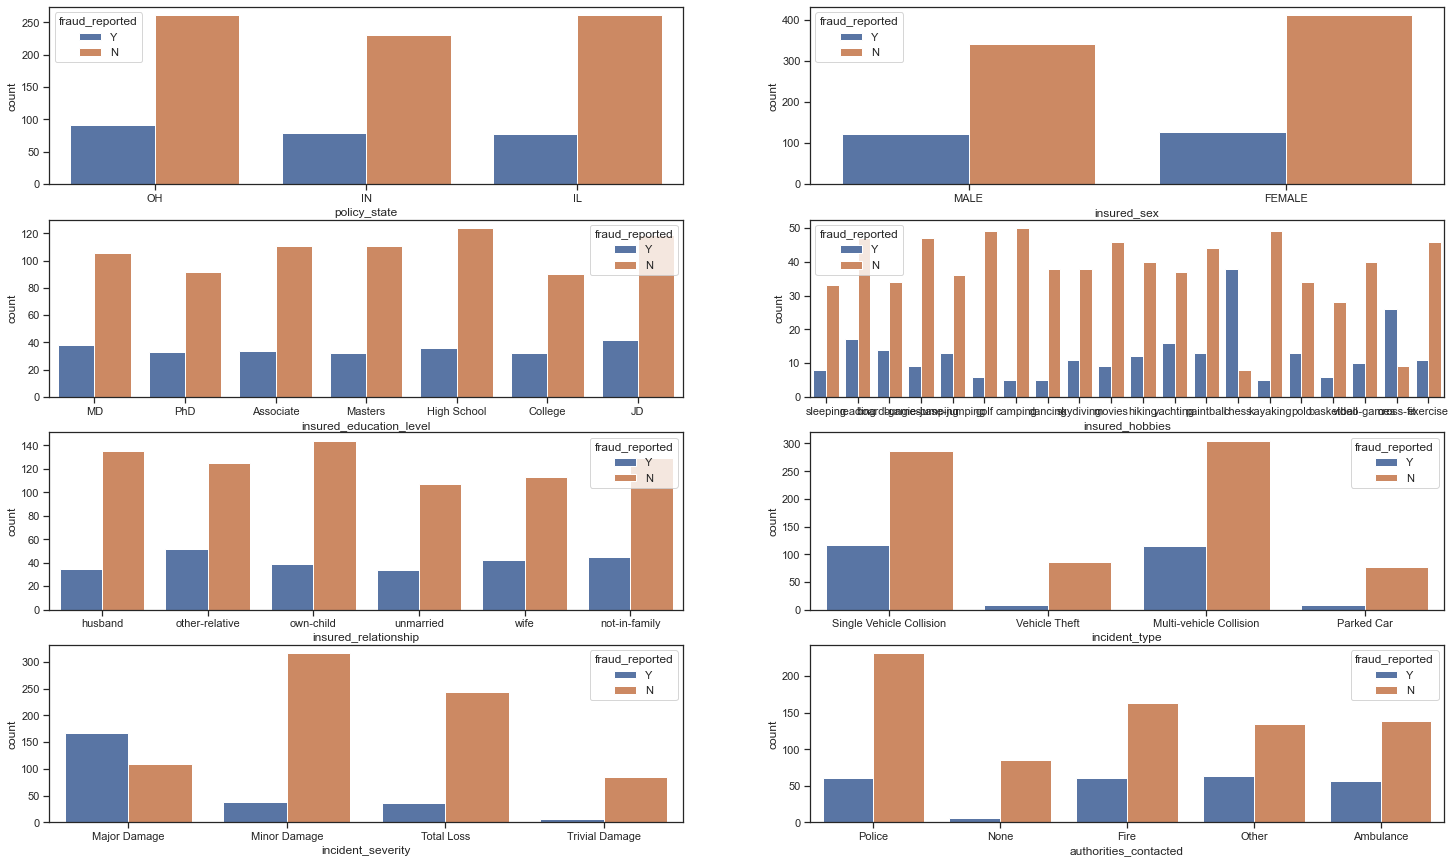

In [23]:
sns.set(style="ticks", color_codes=True)
fig, axes = plt.subplots(nrows = 4,ncols = 2,figsize = (25,15))
sns.countplot(x = "policy_state", data = df, hue = "fraud_reported",ax=axes[0][0])
sns.countplot(x = "insured_sex", data = df, hue = "fraud_reported",ax=axes[0][1])
sns.countplot(x = "insured_education_level", data = df, hue = "fraud_reported",ax=axes[1][0])
sns.countplot(x = "insured_hobbies", data = df, hue = "fraud_reported",ax=axes[1][1])
sns.countplot(x = "insured_relationship", data = df, hue = "fraud_reported",ax=axes[2][0])
sns.countplot(x = "incident_type", data = df,hue = "fraud_reported", ax=axes[2][1])
sns.countplot(x = "incident_severity", data = df,hue = "fraud_reported", ax=axes[3][0])
sns.countplot(x = "authorities_contacted", data = df,hue = "fraud_reported", ax=axes[3][1])
plt.show(fig)

<AxesSubplot:xlabel='fraud_reported', ylabel='vehicle_claim'>

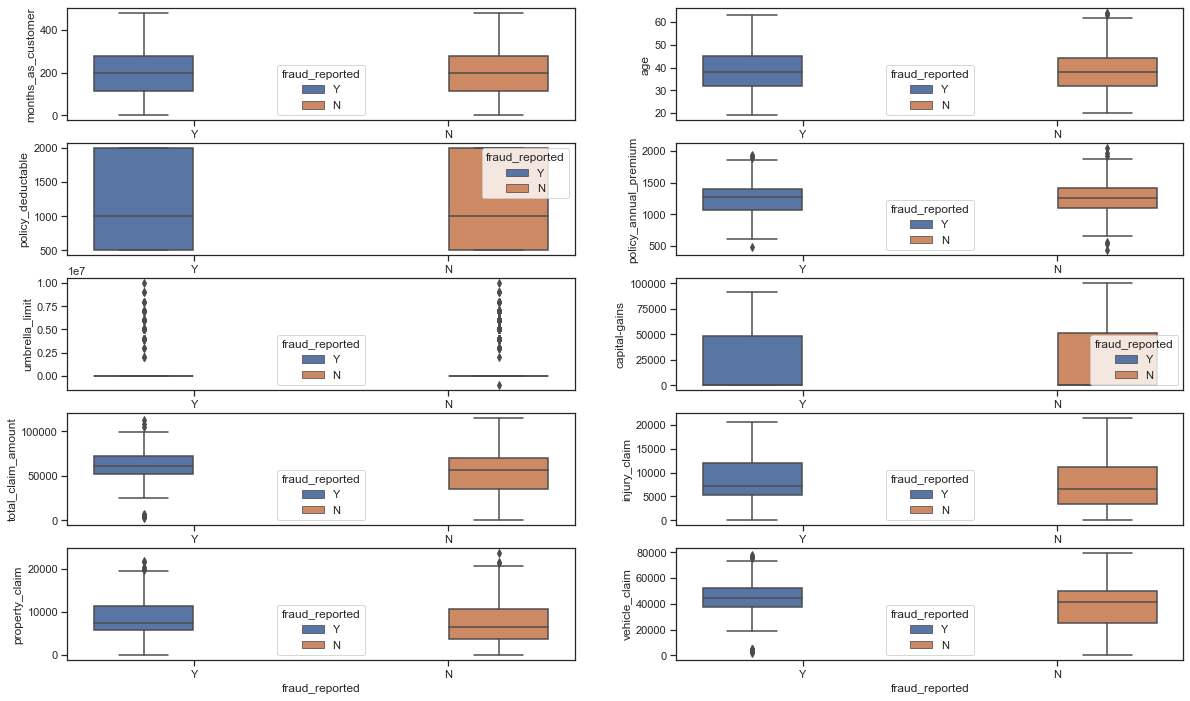

In [24]:
fig, axarr = plt.subplots(5, 2, figsize=(20, 12))
sns.boxplot(y="months_as_customer",x = "fraud_reported", hue = "fraud_reported",data = df, ax=axarr[0][0])
sns.boxplot(y="age",x = "fraud_reported", hue = "fraud_reported",data = df , ax=axarr[0][1])
sns.boxplot(y="policy_deductable",x = "fraud_reported", hue = "fraud_reported",data = df, ax=axarr[1][0])
sns.boxplot(y="policy_annual_premium",x = "fraud_reported", hue = "fraud_reported",data = df, ax=axarr[1][1])
sns.boxplot(y="umbrella_limit",x = "fraud_reported", hue = "fraud_reported",data = df, ax=axarr[2][0])
sns.boxplot(y="capital-gains",x = "fraud_reported", hue = "fraud_reported",data = df, ax=axarr[2][1])
sns.boxplot(y="total_claim_amount",x = "fraud_reported", hue = "fraud_reported",data = df, ax=axarr[3][0])
sns.boxplot(y="injury_claim",x = "fraud_reported", hue = "fraud_reported",data = df, ax=axarr[3][1])
sns.boxplot(y="property_claim",x = "fraud_reported", hue = "fraud_reported",data = df, ax=axarr[4][0])
sns.boxplot(y="vehicle_claim",x = "fraud_reported", hue = "fraud_reported",data = df, ax=axarr[4][1])

In [25]:
df.drop(["umbrella_limit"],axis = 1, inplace = True)

In [26]:
def deeply_plots(df, variable_list):
    for variable in variable_list:
        print(variable)
        plt.figure(figsize=(16, 4))
        # histogram
        plt.subplot(1, 3, 1)
        sns.distplot(df[variable], bins=30)
        plt.title("Histogram")
        # QQ-plot
        plt.subplot(1, 3, 2)
        stats.probplot(df[variable], dist="norm", plot=plt)
        plt.ylabel("quantiles")
        # boxplot
        plt.subplot(1, 3, 3)
        sns.boxplot(y=df[variable])
        plt.title("Boxplot")
        plt.show()

policy_annual_premium


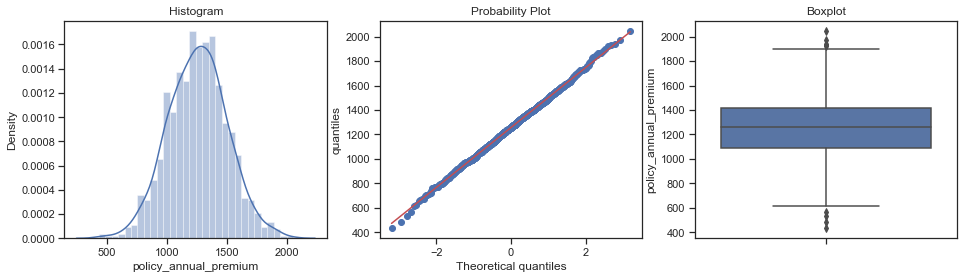

total_claim_amount


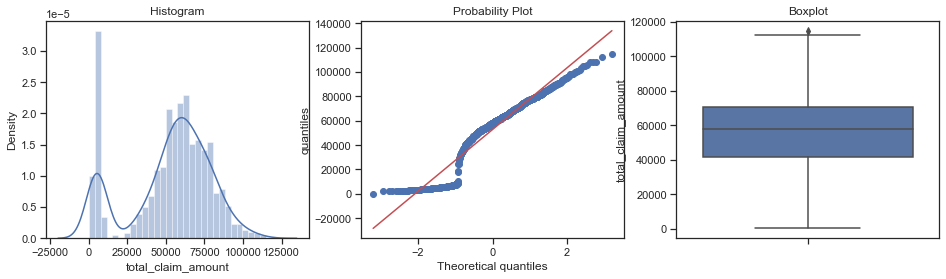

property_claim


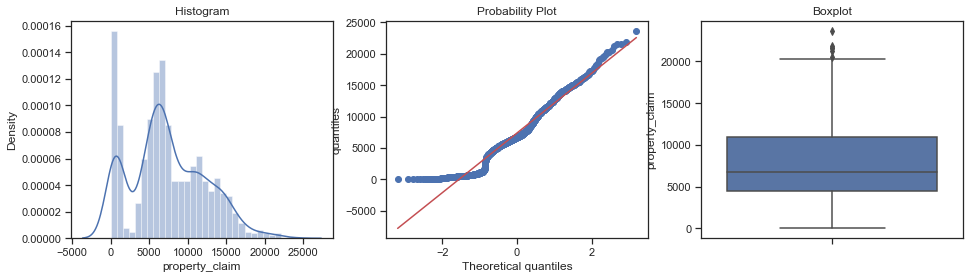

vehicle_claim


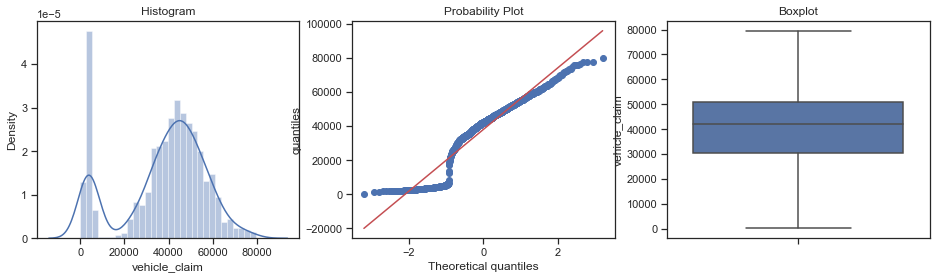

In [27]:
deeply_plots(df, ["policy_annual_premium", "total_claim_amount", "property_claim", "vehicle_claim"])

In [28]:
wind = Winsorizer(distribution = 'skewed',
                  tail = 'both',
                  fold = 1.5,
                  variables=["policy_annual_premium","total_claim_amount","property_claim"])

In [29]:
wind.fit(df)
df = wind.transform(df)

policy_annual_premium


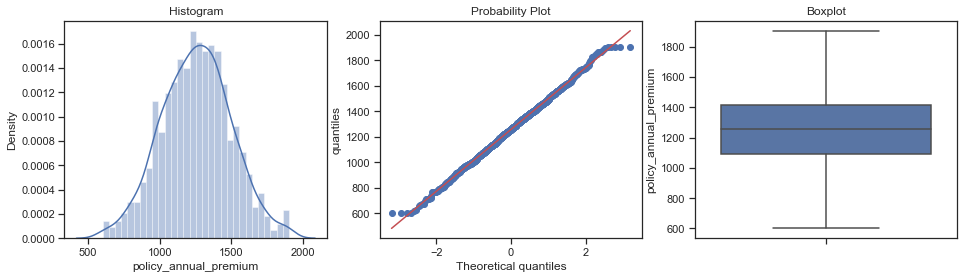

total_claim_amount


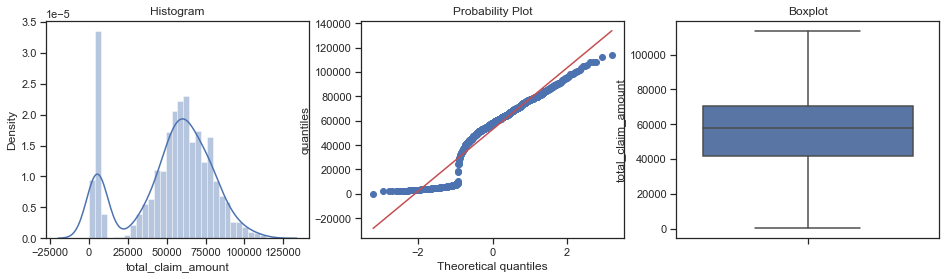

property_claim


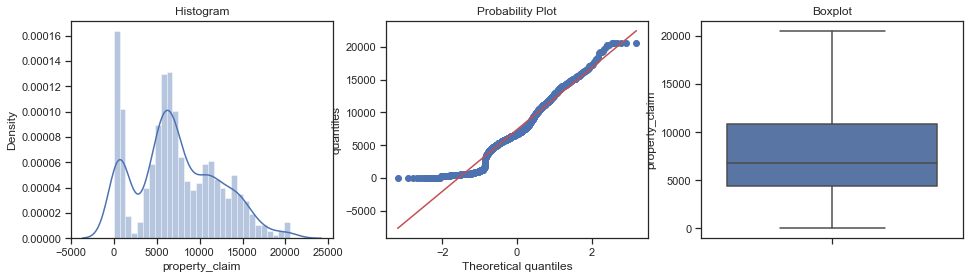

In [30]:
deeply_plots(df, ["policy_annual_premium", "total_claim_amount", "property_claim"])

In [31]:
df["fraud_reported"] = np.where(df["fraud_reported"] == "N",1,0)

In [32]:
df["number_of_vehicles_involved"] = str(df["number_of_vehicles_involved"])
df["bodily_injuries"] = str(df["bodily_injuries"])
df["witnesses"] = str(df["witnesses"])

In [33]:
cat = ["policy_state","policy_csl","insured_sex","insured_education_level","insured_occupation",
       "insured_hobbies","insured_relationship","incident_type","collision_type","incident_severity",
       "authorities_contacted","incident_state","incident_city","number_of_vehicles_involved",
       "property_damage","bodily_injuries","witnesses","police_report_available","make_model"]

In [34]:
df_2 = pd.get_dummies(df[cat],drop_first=True)

df.drop(cat,axis = 1,inplace = True)
df_mod = pd.concat([df,df_2],axis = 1)

In [35]:
y = df_mod["fraud_reported"]
X = df_mod.drop(["fraud_reported"],axis = 1)

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [37]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((800, 128), (200, 128), (800,), (200,))

In [38]:
class FeatureSelector:

    def __init__(self, X_train):
        self.X_train = X_train

    def get_correlation_matrix(self):
        corr_matrix = self.X_train.corr()
        fig, ax = plt.subplots(figsize=(20, 15))
        ax = sns.heatmap(corr_matrix, annot=False, linewidths=0.5, fmt=".2f", cmap="YlGnBu")
        bottom, top = ax.get_ylim()
        ax.set_ylim(bottom + 0.5, top - 0.5)

    @staticmethod
    def correlation(dataset, threshold):
        col_corr = set()
        corr_matrix = dataset.corr()
        for i in range(len(corr_matrix.columns)):
            for j in range(i):
                if abs(corr_matrix.iloc[i, j]) > threshold:
                    colname = corr_matrix.columns[i]
                    col_corr.add(colname)
                    
        return col_corr

    def get_corr_features_len(self):
        corr_features = self.correlation(self.X_train, 0.7)
        return corr_features

    def get_constant_features_len(self):
        constant_features = [
                feat for feat in self.X_train.columns if self.X_train[feat].std() == 0
            ]
        return len(constant_features)

    def get_duplicated_feat_len(self):
        duplicated_feat = []
        for i in range(0, len(self.X_train.columns)):
            if i % 10 == 0:
                print(i)
            col_1 = self.X_train.columns[i]
            for col_2 in self.X_train.columns[i + 1:]:
                if self.X_train[col_1].equals(self.X_train[col_2]):
                    duplicated_feat.append(col_2)

        return len(set(duplicated_feat))
    
    def get_roc_values(self):
        roc_values = []
        for feature in self.X_train.columns:
            clf = RandomForestClassifier()
            clf.fit(self.X_train[feature].fillna(0).to_frame(), y_train)
            y_scored = clf.predict_proba(X_test[feature].fillna(0).to_frame())
            roc_values.append(roc_auc_score(y_test, y_scored[:, 1]))

        roc_values = pd.Series(roc_values)
        roc_values.index = self.X_train.columns
        roc_values.sort_values(ascending=False)

        roc_values.sort_values(ascending=False).plot.bar(figsize=(20, 8))
        return roc_values


In [39]:
feature_selector = FeatureSelector(X_train)

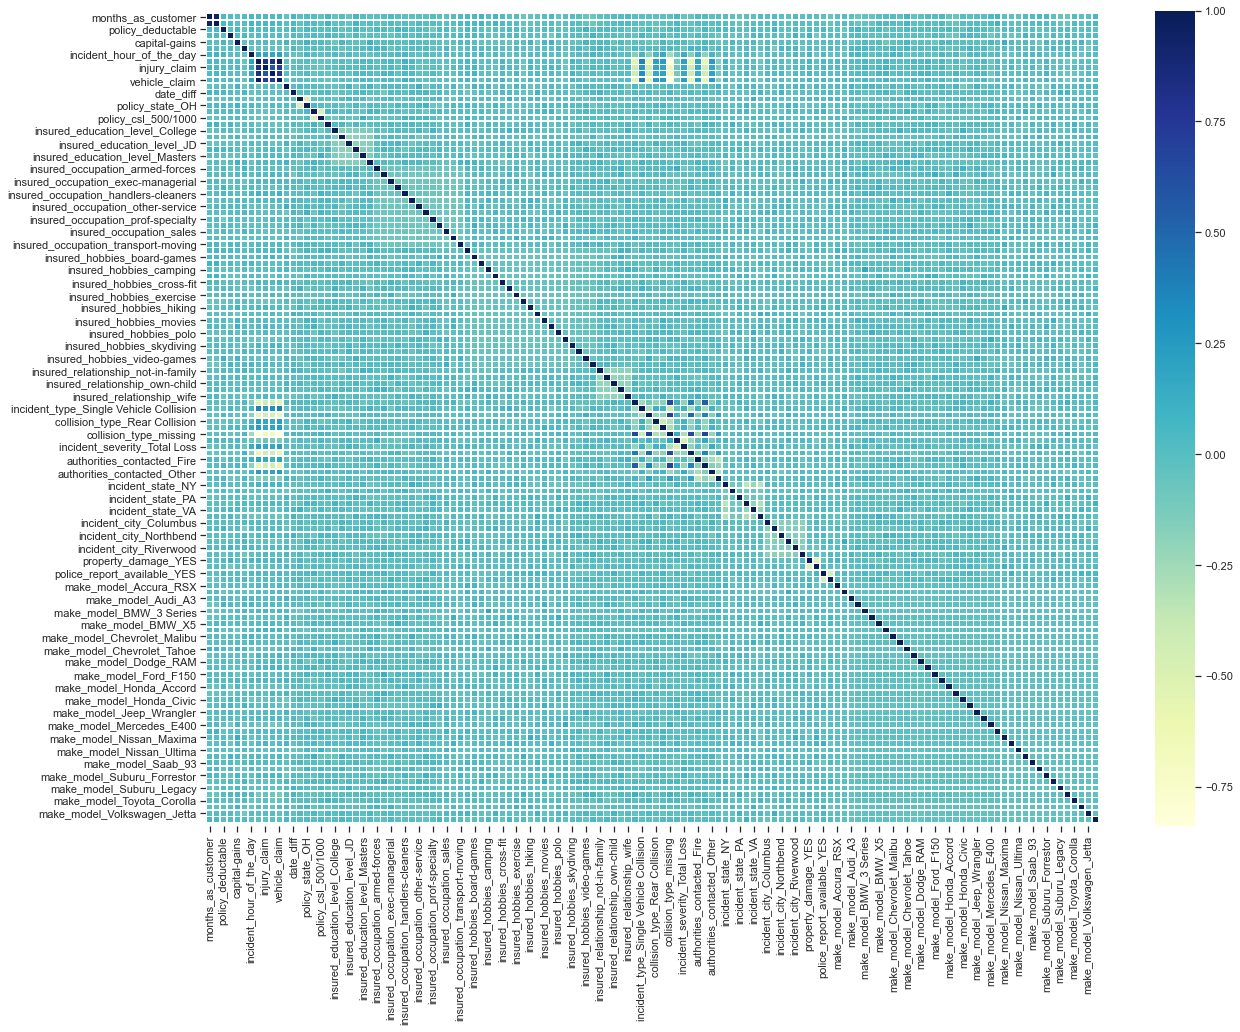

In [40]:
feature_selector.get_correlation_matrix()

In [41]:
feature_selector.get_corr_features_len()

{'age',
 'collision_type_missing',
 'injury_claim',
 'property_claim',
 'vehicle_claim'}

In [42]:
corr_features = feature_selector.get_corr_features_len()

In [43]:
X_train.drop(corr_features, axis = 1,inplace = True)
X_test.drop(corr_features, axis = 1,inplace = True)
X_train.shape,X_test.shape

((800, 123), (200, 123))

In [44]:
feature_selector.get_constant_features_len()

0

In [45]:
feature_selector.get_duplicated_feat_len()

0
10
20
30
40
50
60
70
80
90
100
110
120


0

months_as_customer              0.525329
policy_deductable               0.534232
policy_annual_premium           0.485705
capital-gains                   0.518056
capital-loss                    0.446959
                                  ...   
make_model_Toyota_Camry         0.497806
make_model_Toyota_Corolla       0.504702
make_model_Toyota_Highlander    0.500940
make_model_Volkswagen_Jetta     0.502194
make_model_Volkswagen_Passat    0.479310
Length: 123, dtype: float64

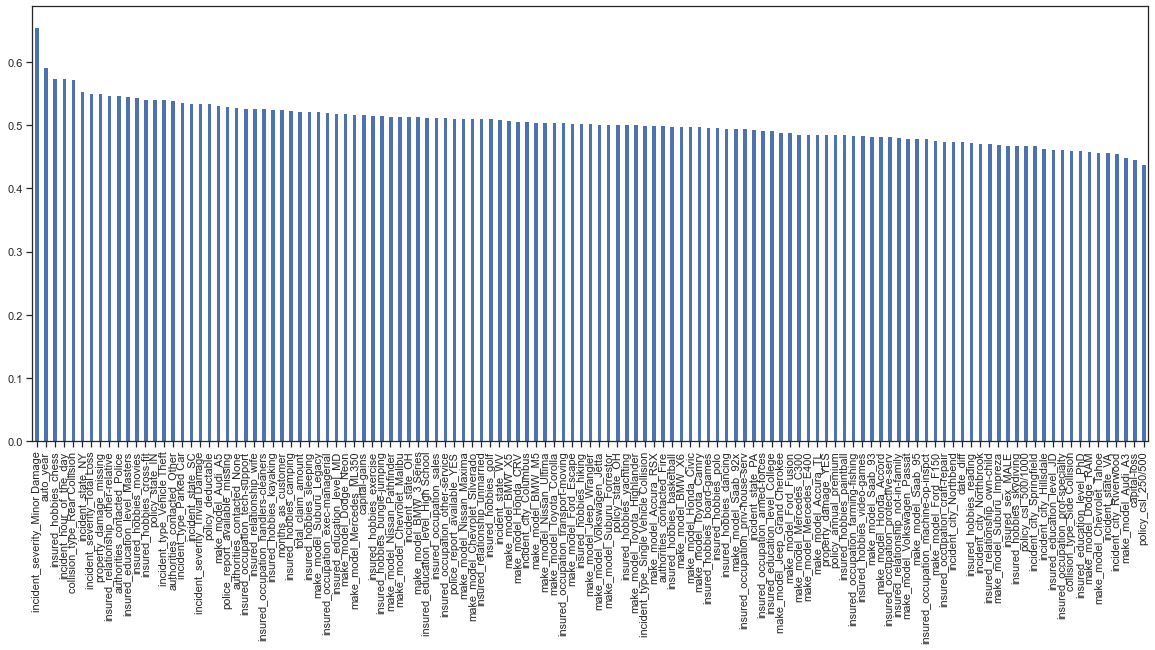

In [46]:
roc_values = feature_selector.get_roc_values()
roc_values

In [47]:
len(roc_values[roc_values > 0.5])

68

In [48]:
drop_list = roc_values[roc_values < 0.5].index

In [49]:
X_train.drop(drop_list,axis = 1,inplace = True)
X_test.drop(drop_list,axis = 1,inplace = True)

In [50]:
X_train.shape,X_test.shape

((800, 70), (200, 70))

In [51]:
sc = StandardScaler()

In [52]:
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [53]:
log = LogisticRegression()

In [54]:
log.fit(X_train,y_train)

LogisticRegression()

In [55]:
log.score(X_train,y_train)

0.87375

In [56]:
y_pred_log = log.predict(X_test)

In [57]:
accuracy_score(y_test,y_pred_log)

0.86

In [58]:
X_train_df = pd.DataFrame(X_train)
X_test_df = pd.DataFrame(X_test)

## Backward Elimination

In [59]:
sfs1 = SFS(LogisticRegression(n_jobs = -1),
           k_features = 15,
           forward = False,
           floating = False,
           verbose = 2,
           scoring = "roc_auc",
           cv = 3)
#stepbackword yaptıgımız için forward kısmını False yaptık
sfs1 = sfs1.fit(np.array(X_train_df.fillna(0)),y_train)
selected_feat = X_train_df.columns[list(sfs1.k_feature_idx_)]
selected_feat

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:   19.3s finished

[2020-11-26 11:00:26] Features: 69/15 -- score: 0.866804552992245[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  69 out of  69 | elapsed:    6.1s finished

[2020-11-26 11:00:32] Features: 68/15 -- score: 0.8707032456632362[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  68 out of  68 | elapsed:    5.9s finished

[2020-11-26 11:00:38] Features: 67/15 -- score: 0.8740645423840414[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done

[Parallel(n_jobs=1)]: Done  43 out of  43 | elapsed:    2.3s finished

[2020-11-26 11:01:57] Features: 42/15 -- score: 0.9077651492058073[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  42 out of  42 | elapsed:    2.0s finished

[2020-11-26 11:01:59] Features: 41/15 -- score: 0.9080219713781723[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  41 out of  41 | elapsed:    1.7s finished

[2020-11-26 11:02:01] Features: 40/15 -- score: 0.9094365255491067[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    1.3s finished

[2020-11-26 11:02:02] Features: 39/

Int64Index([4, 11, 15, 16, 18, 19, 20, 22, 26, 35, 36, 37, 45, 60, 63], dtype='int64')

## Logistic Regression, KNN, SVM

In [60]:

#logistic
logistic =  LogisticRegression(random_state = 0)
logistic.fit(X_train_df[selected_feat], y_train)

#knn
knn = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)
knn.fit(X_train_df[selected_feat], y_train)

#svm
svm = SVC(kernel = 'linear', random_state = 0,probability = True)
svm.fit(X_train_df[selected_feat], y_train)

SVC(kernel='linear', probability=True, random_state=0)

In [61]:
modellist = [logistic,knn,svm]
for model in modellist:
    print(model.score(X_train_df[selected_feat],y_train))

0.87625
0.87625
0.8725


In [62]:
mods   = ['Logistic Regression','KNN Classifier','SVM Classifier Linear']
for i,k in zip(modellist,mods):
    predictions = i.predict(X_test_df[selected_feat])
    print("{}".format(k))
    print(classification_report(y_test,predictions))

Logistic Regression
              precision    recall  f1-score   support

           0       0.71      0.75      0.73        55
           1       0.90      0.88      0.89       145

    accuracy                           0.84       200
   macro avg       0.80      0.81      0.81       200
weighted avg       0.85      0.84      0.85       200

KNN Classifier
              precision    recall  f1-score   support

           0       0.67      0.69      0.68        55
           1       0.88      0.87      0.87       145

    accuracy                           0.82       200
   macro avg       0.77      0.78      0.78       200
weighted avg       0.82      0.82      0.82       200

SVM Classifier Linear
              precision    recall  f1-score   support

           0       0.66      0.85      0.75        55
           1       0.94      0.83      0.88       145

    accuracy                           0.84       200
   macro avg       0.80      0.84      0.81       200
weighted avg     

## ANN

In [63]:
model = tfs.keras.models.Sequential((tfs.keras.layers.Dense(units = 6, kernel_initializer = 'uniform', 
                                                               activation = 'relu', input_dim = 15),
                                         tfs.keras.layers.Dense(units = 6, kernel_initializer = 'uniform', 
                                                                activation = 'relu'),
                                         tfs.keras.layers.Dense(units = 10, kernel_initializer = 'uniform', 
                                                                activation = 'relu'),
                                         tfs.keras.layers.Dense(units = 6, kernel_initializer = 'uniform', 
                                                                activation = 'relu'),
                                         tfs.keras.layers.Dense(units = 1, kernel_initializer = 'uniform', 
                                                               activation = 'sigmoid')))

model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [64]:
model.fit(X_train_df[selected_feat],y_train,batch_size = 100, epochs = 500)

Train on 800 samples
Epoch 1/500
800/800 [==============================] - 0s 450us/sample - loss: 0.6922 - accuracy: 0.7025
Epoch 2/500
800/800 [==============================] - 0s 54us/sample - loss: 0.6902 - accuracy: 0.7600
Epoch 3/500
800/800 [==============================] - 0s 40us/sample - loss: 0.6882 - accuracy: 0.7600
Epoch 4/500
800/800 [==============================] - 0s 42us/sample - loss: 0.6862 - accuracy: 0.7600
Epoch 5/500
800/800 [==============================] - 0s 56us/sample - loss: 0.6843 - accuracy: 0.7600
Epoch 6/500
800/800 [==============================] - 0s 49us/sample - loss: 0.6822 - accuracy: 0.7600
Epoch 7/500
800/800 [==============================] - 0s 45us/sample - loss: 0.6803 - accuracy: 0.7600
Epoch 8/500
800/800 [==============================] - 0s 39us/sample - loss: 0.6784 - accuracy: 0.7600
Epoch 9/500
800/800 [==============================] - 0s 35us/sample - loss: 0.6765 - accuracy: 0.7600
Epoch 10/500
800/800 [====================

800/800 [==============================] - 0s 44us/sample - loss: 0.5917 - accuracy: 0.7600
Epoch 78/500
800/800 [==============================] - 0s 54us/sample - loss: 0.5910 - accuracy: 0.7600
Epoch 79/500
800/800 [==============================] - 0s 47us/sample - loss: 0.5902 - accuracy: 0.7600
Epoch 80/500
800/800 [==============================] - 0s 49us/sample - loss: 0.5895 - accuracy: 0.7600
Epoch 81/500
800/800 [==============================] - 0s 97us/sample - loss: 0.5888 - accuracy: 0.7600
Epoch 82/500
800/800 [==============================] - 0s 56us/sample - loss: 0.5881 - accuracy: 0.7600
Epoch 83/500
800/800 [==============================] - 0s 64us/sample - loss: 0.5874 - accuracy: 0.7600
Epoch 84/500
800/800 [==============================] - 0s 50us/sample - loss: 0.5867 - accuracy: 0.7600
Epoch 85/500
800/800 [==============================] - 0s 41us/sample - loss: 0.5861 - accuracy: 0.7600
Epoch 86/500
800/800 [==============================] - 0s 44us/samp

800/800 [==============================] - 0s 54us/sample - loss: 0.5595 - accuracy: 0.7600
Epoch 154/500
800/800 [==============================] - 0s 54us/sample - loss: 0.5593 - accuracy: 0.7600
Epoch 155/500
800/800 [==============================] - 0s 54us/sample - loss: 0.5591 - accuracy: 0.7600
Epoch 156/500
800/800 [==============================] - 0s 75us/sample - loss: 0.5589 - accuracy: 0.7600
Epoch 157/500
800/800 [==============================] - 0s 62us/sample - loss: 0.5587 - accuracy: 0.7600
Epoch 158/500
800/800 [==============================] - 0s 44us/sample - loss: 0.5586 - accuracy: 0.7600
Epoch 159/500
800/800 [==============================] - 0s 49us/sample - loss: 0.5584 - accuracy: 0.7600
Epoch 160/500
800/800 [==============================] - 0s 49us/sample - loss: 0.5582 - accuracy: 0.7600
Epoch 161/500
800/800 [==============================] - 0s 66us/sample - loss: 0.5580 - accuracy: 0.7600
Epoch 162/500
800/800 [==============================] - 0s 

800/800 [==============================] - 0s 40us/sample - loss: 0.5522 - accuracy: 0.7600
Epoch 231/500
800/800 [==============================] - 0s 30us/sample - loss: 0.5521 - accuracy: 0.7600
Epoch 232/500
800/800 [==============================] - 0s 31us/sample - loss: 0.5521 - accuracy: 0.7600
Epoch 233/500
800/800 [==============================] - 0s 29us/sample - loss: 0.5521 - accuracy: 0.7600
Epoch 234/500
800/800 [==============================] - 0s 29us/sample - loss: 0.5520 - accuracy: 0.7600
Epoch 235/500
800/800 [==============================] - 0s 34us/sample - loss: 0.5520 - accuracy: 0.7600
Epoch 236/500
800/800 [==============================] - 0s 37us/sample - loss: 0.5520 - accuracy: 0.7600
Epoch 237/500
800/800 [==============================] - 0s 29us/sample - loss: 0.5520 - accuracy: 0.7600
Epoch 238/500
800/800 [==============================] - 0s 36us/sample - loss: 0.5519 - accuracy: 0.7600
Epoch 239/500
800/800 [==============================] - 0s 

800/800 [==============================] - 0s 49us/sample - loss: 0.5512 - accuracy: 0.7600
Epoch 308/500
800/800 [==============================] - 0s 48us/sample - loss: 0.5512 - accuracy: 0.7600
Epoch 309/500
800/800 [==============================] - 0s 46us/sample - loss: 0.5512 - accuracy: 0.7600
Epoch 310/500
800/800 [==============================] - 0s 55us/sample - loss: 0.5511 - accuracy: 0.7600
Epoch 311/500
800/800 [==============================] - 0s 55us/sample - loss: 0.5511 - accuracy: 0.7600
Epoch 312/500
800/800 [==============================] - 0s 64us/sample - loss: 0.5511 - accuracy: 0.7600
Epoch 313/500
800/800 [==============================] - 0s 54us/sample - loss: 0.5511 - accuracy: 0.7600
Epoch 314/500
800/800 [==============================] - 0s 54us/sample - loss: 0.5512 - accuracy: 0.7600
Epoch 315/500
800/800 [==============================] - 0s 54us/sample - loss: 0.5511 - accuracy: 0.7600
Epoch 316/500
800/800 [==============================] - 0s 

800/800 [==============================] - 0s 31us/sample - loss: 0.5511 - accuracy: 0.7600
Epoch 385/500
800/800 [==============================] - 0s 34us/sample - loss: 0.5511 - accuracy: 0.7600
Epoch 386/500
800/800 [==============================] - 0s 45us/sample - loss: 0.5511 - accuracy: 0.7600
Epoch 387/500
800/800 [==============================] - 0s 38us/sample - loss: 0.5511 - accuracy: 0.7600
Epoch 388/500
800/800 [==============================] - 0s 33us/sample - loss: 0.5511 - accuracy: 0.7600
Epoch 389/500
800/800 [==============================] - 0s 21us/sample - loss: 0.5511 - accuracy: 0.7600
Epoch 390/500
800/800 [==============================] - 0s 23us/sample - loss: 0.5511 - accuracy: 0.7600
Epoch 391/500
800/800 [==============================] - 0s 23us/sample - loss: 0.5511 - accuracy: 0.7600
Epoch 392/500
800/800 [==============================] - 0s 22us/sample - loss: 0.5511 - accuracy: 0.7600
Epoch 393/500
800/800 [==============================] - 0s 

800/800 [==============================] - 0s 30us/sample - loss: 0.5511 - accuracy: 0.7600
Epoch 462/500
800/800 [==============================] - 0s 44us/sample - loss: 0.5511 - accuracy: 0.7600
Epoch 463/500
800/800 [==============================] - 0s 27us/sample - loss: 0.5511 - accuracy: 0.7600
Epoch 464/500
800/800 [==============================] - 0s 30us/sample - loss: 0.5511 - accuracy: 0.7600
Epoch 465/500
800/800 [==============================] - 0s 40us/sample - loss: 0.5511 - accuracy: 0.7600
Epoch 466/500
800/800 [==============================] - 0s 30us/sample - loss: 0.5511 - accuracy: 0.7600
Epoch 467/500
800/800 [==============================] - 0s 34us/sample - loss: 0.5511 - accuracy: 0.7600
Epoch 468/500
800/800 [==============================] - 0s 40us/sample - loss: 0.5511 - accuracy: 0.7600
Epoch 469/500
800/800 [==============================] - 0s 42us/sample - loss: 0.5511 - accuracy: 0.7600
Epoch 470/500
800/800 [==============================] - 0s 

In [65]:
y_pred = model.predict(X_test_df[selected_feat])
y_pred = (y_pred > 0.5)

In [66]:
score = accuracy_score(y_test,y_pred)
score


0.725

In [67]:
param_grid={"C": [0.001,0.01,0.1,1,10,100,1000], "penalty":["l1","l2"]}
clf=LogisticRegression()
logreg_cv=GridSearchCV(clf,param_grid,cv=10)

In [68]:
logreg_cv.fit(X_train_df[selected_feat],y_train)

GridSearchCV(cv=10, estimator=LogisticRegression(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'penalty': ['l1', 'l2']})

In [69]:
print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 0.1, 'penalty': 'l2'}
accuracy : 0.8675


In [70]:
y_prediction = logreg_cv.predict(X_test_df[selected_feat])

cm = confusion_matrix(y_test,y_prediction)

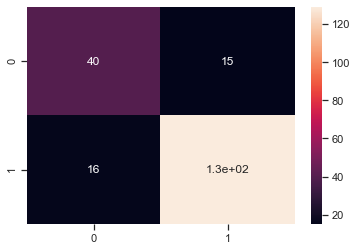

In [71]:
sns.heatmap(cm,annot=True)
plt.savefig('h.png')

In [72]:
accuracy_score(y_test,y_prediction)

0.845